In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


#### Data_preparetion


In [51]:
# Import data 
target_assay = 'transduction'
array = 'AA_sequence'

df_all = pd.read_csv('../data/1stseq_aa_transduction.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[['AA_sequence', target_assay]]
df= df.sort_values(by=target_assay)

#Fill in the nan data and replace the inf value
df[target_assay] = df[target_assay].fillna(0)  
df[target_assay] = df[target_assay].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[target_assay,'AA_sequence'])
# df = df.iloc[::50]
df

,AA_sequence,transduction
5233,FRQGSVS,-16.459544
572,IGGRVSA,-16.317739
5812,RRGEGVN,-16.047279
3895,LFRSGVG,-15.042787
2311,ISNNTRG,-14.920620
...,...,...
6467,CGISGDG,8.701060
3742,GKRSGGI,8.780375
6211,MRAVNVK,8.813766
8327,YTDLQFI,9.087205


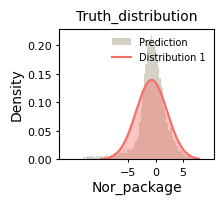

In [52]:
nor_package = df_all[np.isfinite(df_all[target_assay])][target_assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 8, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

### Prep data and make Tensorflow-compatible data batches

`prep_data()` will one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split
futher into training and validation batches with `make_tf_batches()`.


In [53]:
(data_list, train_df, test_df, prepped_df) = prep_data(df, AA_colname=array, target_assay_col=target_assay)
train_df['Y--transduction'] = train_df[array].map(df.drop_duplicates(array).set_index(array)[target_assay])
test_df['Y--transduction'] = test_df[array].map(df.drop_duplicates(array).set_index(array)[target_assay])
prepped_df['Y--transduction'] = test_df[array].map(df.drop_duplicates(array).set_index(array)[target_assay])

In [54]:
train_df

,AA_sequence,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x131,x132,x133,x134,x135,x136,x137,x138,x139,Y--transduction
0,IGGRVSA,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-16.317739
1,RRGEGVN,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-16.047279
2,ISNNTRG,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-14.920620
3,SGQNSHQ,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-14.750743
4,YSVKTSV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-14.718122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9184,CGISGDG,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.701060
9185,GKRSGGI,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,8.780375
9186,MRAVNVK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.813766
9187,YTDLQFI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.087205


In [55]:
train_df.isnull().describe()
prepped_df.isnull().describe()

,AA_sequence,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x132,x133,x134,x135,x136,x137,x138,x139,Y--transduction,test
count,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,...,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
freq,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,...,10209,10209,10209,10209,10209,10209,10209,10209,9189,10209


Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [56]:
X, Y  = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y)

## VAE  model training

Default parameterization:Here the model is applied to aa-nor_package learning process, as details

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [57]:
# SVAE parameters (same as default)
input_dim = 140
latent_dim = 2
enc_hidden_dims = [100,40]
dec_hidden_dims = [40,100]
reg_hidden_dims = [100,10]

# training parameters 

outpath = 'pretrain/vae/1st_aa_nor_transduction'
loss_weights = [1.0,0.8,1.5] # [reconstruction, KL, regression]

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=140, latent_dim=2, enc_hidden_dims=[100,40], dec_hidden_dims=[40,100], reg_hidden_dims=[100,10], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 140)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  18304     ['encoder_input[0][0]',       
                              (None, 2),                             'encoder_input[0][0]']       
                              (None, 2)]                                                          
                                                                                                  
 tf.concat_5 (TFOpLambda)    (None, 142)                  0         ['encoder[1][0]',             
                                                                     'encoder_input[0][0]']    

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [58]:
# Train model
model, preds_df, model_outdir = train_new(model, train_batches, val_batches, array,outpath,
                                        train_df, optimizer=optimizer,                    
                                        loss_weights=loss_weights           
                        )

Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
4087/4087 [==============================] - 42s 10ms/step - train_model_loss: 31.7741 - train_reconstruction_loss: 19.5199 - train_kl_loss: 0.0078 - train_regression_loss: 8.1449 - val_model_loss: 31.7305 - val_reconstruction_loss: 19.3444 - val_kl_loss: 0.0028 - val_regression_loss: 8.2615


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 2
4087/4087 [==============================] - 42s 10ms/step - train_model_loss: 31.6004 - train_reconstruction_loss: 19.3761 - train_kl_loss: 0.0015 - train_regression_loss: 8.1375 - val_model_loss: 30.4033 - val_reconstruction_loss: 19.3039 - val_kl_loss: 6.6734e-04 - val_regression_loss: 7.4022


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 3
4087/4087 [==============================] - 43s 10ms/step - train_model_loss: 31.3415 - train_reconstruction_loss: 19.3730 - train_kl_loss: 7.0422e-04 - train_regression_loss: 7.9679 - val_model_loss: 30.2971 - val_reconstruction_loss: 19.3309 - val_kl_loss: 3.9927e-04 - val_regression_loss: 7.2997


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 4
4087/4087 [==============================] - 44s 11ms/step - train_model_loss: 31.4853 - train_reconstruction_loss: 19.3567 - train_kl_loss: 3.4599e-04 - train_regression_loss: 8.0820 - val_model_loss: 31.1393 - val_reconstruction_loss: 19.2761 - val_kl_loss: 2.6964e-04 - val_regression_loss: 7.9116


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 5
4087/4087 [==============================] - 43s 10ms/step - train_model_loss: 31.1521 - train_reconstruction_loss: 19.3609 - train_kl_loss: 1.7307e-04 - train_regression_loss: 7.8503 - val_model_loss: 30.6291 - val_reconstruction_loss: 19.3549 - val_kl_loss: 1.3680e-04 - val_regression_loss: 7.5207


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 6
4087/4087 [==============================] - 43s 11ms/step - train_model_loss: 30.9310 - train_reconstruction_loss: 19.3387 - train_kl_loss: 2.0779e-04 - train_regression_loss: 7.8032 - val_model_loss: 30.9934 - val_reconstruction_loss: 19.3148 - val_kl_loss: 1.3088e-04 - val_regression_loss: 7.7808


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 7
4087/4087 [==============================] - 39s 9ms/step - train_model_loss: 31.1009 - train_reconstruction_loss: 19.3557 - train_kl_loss: 2.8811e-04 - train_regression_loss: 7.8300 - val_model_loss: 29.8136 - val_reconstruction_loss: 19.3832 - val_kl_loss: 1.6920e-04 - val_regression_loss: 6.9465


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 8
4087/4087 [==============================] - 39s 9ms/step - train_model_loss: 30.9329 - train_reconstruction_loss: 19.3423 - train_kl_loss: 3.5756e-04 - train_regression_loss: 7.7067 - val_model_loss: 31.1961 - val_reconstruction_loss: 19.3561 - val_kl_loss: 5.1906e-04 - val_regression_loss: 7.9286


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 9
4087/4087 [==============================] - 39s 10ms/step - train_model_loss: 30.8083 - train_reconstruction_loss: 19.3477 - train_kl_loss: 0.0048 - train_regression_loss: 7.6225 - val_model_loss: 29.3848 - val_reconstruction_loss: 19.3189 - val_kl_loss: 0.0061 - val_regression_loss: 6.7147


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 10
4087/4087 [==============================] - 40s 10ms/step - train_model_loss: 30.8029 - train_reconstruction_loss: 19.3548 - train_kl_loss: 0.0018 - train_regression_loss: 7.6259 - val_model_loss: 31.4127 - val_reconstruction_loss: 19.3767 - val_kl_loss: 1.9598e-04 - val_regression_loss: 8.0148


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 11
4087/4087 [==============================] - 39s 10ms/step - train_model_loss: 30.5696 - train_reconstruction_loss: 19.3367 - train_kl_loss: 0.0011 - train_regression_loss: 7.4733 - val_model_loss: 30.6761 - val_reconstruction_loss: 19.2710 - val_kl_loss: 9.6353e-04 - val_regression_loss: 7.6095


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 12
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 30.3101 - train_reconstruction_loss: 19.3361 - train_kl_loss: 6.7263e-04 - train_regression_loss: 7.3192 - val_model_loss: 30.7129 - val_reconstruction_loss: 19.3381 - val_kl_loss: 1.1112e-04 - val_regression_loss: 7.5803


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 13
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 30.1821 - train_reconstruction_loss: 19.3513 - train_kl_loss: 1.4157e-04 - train_regression_loss: 7.2208 - val_model_loss: 30.6836 - val_reconstruction_loss: 19.2929 - val_kl_loss: 2.8792e-04 - val_regression_loss: 7.5989


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 14
4087/4087 [==============================] - 40s 10ms/step - train_model_loss: 30.2393 - train_reconstruction_loss: 19.3362 - train_kl_loss: 7.8071e-04 - train_regression_loss: 7.2533 - val_model_loss: 29.7352 - val_reconstruction_loss: 19.3409 - val_kl_loss: 0.0029 - val_regression_loss: 6.9259


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 15
4087/4087 [==============================] - 39s 9ms/step - train_model_loss: 29.6533 - train_reconstruction_loss: 19.3366 - train_kl_loss: 0.0019 - train_regression_loss: 6.8821 - val_model_loss: 28.9816 - val_reconstruction_loss: 19.3627 - val_kl_loss: 0.0016 - val_regression_loss: 6.4259


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 16
4087/4087 [==============================] - 40s 10ms/step - train_model_loss: 29.8370 - train_reconstruction_loss: 19.3339 - train_kl_loss: 9.5843e-04 - train_regression_loss: 7.0360 - val_model_loss: 28.4181 - val_reconstruction_loss: 19.3355 - val_kl_loss: 5.3182e-04 - val_regression_loss: 6.0593


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 17
4087/4087 [==============================] - 41s 10ms/step - train_model_loss: 29.7339 - train_reconstruction_loss: 19.3450 - train_kl_loss: 3.6778e-04 - train_regression_loss: 6.9728 - val_model_loss: 28.8233 - val_reconstruction_loss: 19.3302 - val_kl_loss: 3.7475e-04 - val_regression_loss: 6.3243


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 18
4087/4087 [==============================] - 41s 10ms/step - train_model_loss: 29.2432 - train_reconstruction_loss: 19.3381 - train_kl_loss: 1.4045e-04 - train_regression_loss: 6.5958 - val_model_loss: 29.1422 - val_reconstruction_loss: 19.3203 - val_kl_loss: 7.1484e-05 - val_regression_loss: 6.5571


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 19
4087/4087 [==============================] - 40s 10ms/step - train_model_loss: 28.8230 - train_reconstruction_loss: 19.3537 - train_kl_loss: 1.5274e-04 - train_regression_loss: 6.3039 - val_model_loss: 27.3110 - val_reconstruction_loss: 19.2822 - val_kl_loss: 1.2655e-04 - val_regression_loss: 5.3494


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 20
4087/4087 [==============================] - 39s 9ms/step - train_model_loss: 28.4373 - train_reconstruction_loss: 19.3395 - train_kl_loss: 1.3315e-04 - train_regression_loss: 6.0657 - val_model_loss: 27.6484 - val_reconstruction_loss: 19.2951 - val_kl_loss: 3.2993e-04 - val_regression_loss: 5.5621


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 21
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 28.2376 - train_reconstruction_loss: 19.3399 - train_kl_loss: 2.0203e-04 - train_regression_loss: 5.9564 - val_model_loss: 27.0630 - val_reconstruction_loss: 19.3446 - val_kl_loss: 1.5347e-04 - val_regression_loss: 5.1636


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 22
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 27.8670 - train_reconstruction_loss: 19.3304 - train_kl_loss: 1.4511e-04 - train_regression_loss: 5.7151 - val_model_loss: 26.2626 - val_reconstruction_loss: 19.3081 - val_kl_loss: 1.5242e-04 - val_regression_loss: 4.6418


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 23
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 27.6122 - train_reconstruction_loss: 19.3399 - train_kl_loss: 3.6403e-04 - train_regression_loss: 5.5387 - val_model_loss: 26.7937 - val_reconstruction_loss: 19.3254 - val_kl_loss: 0.0408 - val_regression_loss: 4.9684


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 24
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 27.2185 - train_reconstruction_loss: 19.3473 - train_kl_loss: 0.0074 - train_regression_loss: 5.2362 - val_model_loss: 26.7745 - val_reconstruction_loss: 19.2969 - val_kl_loss: 0.0020 - val_regression_loss: 4.9830


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 25
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 26.7938 - train_reconstruction_loss: 19.3431 - train_kl_loss: 0.0019 - train_regression_loss: 4.9564 - val_model_loss: 26.1094 - val_reconstruction_loss: 19.2845 - val_kl_loss: 0.0018 - val_regression_loss: 4.5441


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 26
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 26.5562 - train_reconstruction_loss: 19.3407 - train_kl_loss: 0.0033 - train_regression_loss: 4.8029 - val_model_loss: 25.5875 - val_reconstruction_loss: 19.3083 - val_kl_loss: 0.0023 - val_regression_loss: 4.1908


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 27
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 26.2965 - train_reconstruction_loss: 19.3511 - train_kl_loss: 7.0623e-04 - train_regression_loss: 4.6388 - val_model_loss: 25.9094 - val_reconstruction_loss: 19.3238 - val_kl_loss: 5.3581e-04 - val_regression_loss: 4.3841


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 28
4087/4087 [==============================] - 43518s 11s/step - train_model_loss: 25.9026 - train_reconstruction_loss: 19.3528 - train_kl_loss: 2.2910e-04 - train_regression_loss: 4.3733 - val_model_loss: 24.9289 - val_reconstruction_loss: 19.3424 - val_kl_loss: 1.6893e-04 - val_regression_loss: 3.7182


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 29
4087/4087 [==============================] - 46s 11ms/step - train_model_loss: 25.5780 - train_reconstruction_loss: 19.3399 - train_kl_loss: 2.0070e-04 - train_regression_loss: 4.1510 - val_model_loss: 24.5190 - val_reconstruction_loss: 19.3475 - val_kl_loss: 3.8257e-04 - val_regression_loss: 3.4434


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 30
4087/4087 [==============================] - 43s 10ms/step - train_model_loss: 25.3043 - train_reconstruction_loss: 19.3339 - train_kl_loss: 1.7339e-04 - train_regression_loss: 3.9743 - val_model_loss: 24.9113 - val_reconstruction_loss: 19.3244 - val_kl_loss: 1.1022e-04 - val_regression_loss: 3.7293


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.
Convergence history: [1]

epoch 31
4087/4087 [==============================] - 46s 11ms/step - train_model_loss: 25.0294 - train_reconstruction_loss: 19.3319 - train_kl_loss: 1.7584e-04 - train_regression_loss: 3.7916 - val_model_loss: 24.1568 - val_reconstruction_loss: 19.3426 - val_kl_loss: 3.2439e-04 - val_regression_loss: 3.2080


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.
Convergence history: [1, 1]

epoch 32
4087/4087 [==============================] - 40s 10ms/step - train_model_loss: 24.9043 - train_reconstruction_loss: 19.3359 - train_kl_loss: 1.8248e-04 - train_regression_loss: 3.7051 - val_model_loss: 24.7634 - val_reconstruction_loss: 19.3653 - val_kl_loss: 1.4937e-04 - val_regression_loss: 3.5979


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.
Convergence history: [1, 1, 1]

epoch 33
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 24.6821 - train_reconstruction_loss: 19.3347 - train_kl_loss: 1.8903e-04 - train_regression_loss: 3.5570 - val_model_loss: 23.8645 - val_reconstruction_loss: 19.3035 - val_kl_loss: 1.4322e-04 - val_regression_loss: 3.0455


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.
Convergence history: [1, 1, 1, 1]

epoch 34
4087/4087 [==============================] - 39s 10ms/step - train_model_loss: 24.5451 - train_reconstruction_loss: 19.3355 - train_kl_loss: 1.6780e-04 - train_regression_loss: 3.4785 - val_model_loss: 23.6405 - val_reconstruction_loss: 19.3067 - val_kl_loss: 2.3122e-04 - val_regression_loss: 2.8913


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.
Convergence history: [1, 1, 1, 1, 1]

epoch 35
Converged. Stall: 1/10
4087/4087 [==============================] - 39s 10ms/step - train_model_loss: 24.3001 - train_reconstruction_loss: 19.3564 - train_kl_loss: 2.8928e-04 - train_regression_loss: 3.3120 - val_model_loss: 23.8402 - val_reconstruction_loss: 19.3639 - val_kl_loss: 9.4415e-04 - val_regression_loss: 2.9914


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 36
Converged. Stall: 2/10
4087/4087 [==============================] - 39s 9ms/step - train_model_loss: 24.0060 - train_reconstruction_loss: 19.3127 - train_kl_loss: 0.0026 - train_regression_loss: 3.1344 - val_model_loss: 23.7861 - val_reconstruction_loss: 19.3044 - val_kl_loss: 0.0011 - val_regression_loss: 2.9876


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 37
Converged. Stall: 3/10
4087/4087 [==============================] - 41s 10ms/step - train_model_loss: 23.7768 - train_reconstruction_loss: 19.3415 - train_kl_loss: 6.0633e-04 - train_regression_loss: 2.9580 - val_model_loss: 23.5660 - val_reconstruction_loss: 19.3205 - val_kl_loss: 8.5936e-04 - val_regression_loss: 2.8241


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 38
Converged. Stall: 4/10
4087/4087 [==============================] - 38s 9ms/step - train_model_loss: 23.7431 - train_reconstruction_loss: 19.3402 - train_kl_loss: 4.9451e-04 - train_regression_loss: 2.9301 - val_model_loss: 23.5864 - val_reconstruction_loss: 19.3197 - val_kl_loss: 3.0882e-04 - val_regression_loss: 2.8488


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 39
Converged. Stall: 5/10
4087/4087 [==============================] - 37s 9ms/step - train_model_loss: 23.5503 - train_reconstruction_loss: 19.3361 - train_kl_loss: 3.6857e-04 - train_regression_loss: 2.8074 - val_model_loss: 22.9156 - val_reconstruction_loss: 19.3158 - val_kl_loss: 3.1531e-04 - val_regression_loss: 2.3988


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.

epoch 40
Converged. Stall: 6/10
4087/4087 [==============================] - 39s 10ms/step - train_model_loss: 23.2726 - train_reconstruction_loss: 19.3366 - train_kl_loss: 6.1987e-04 - train_regression_loss: 2.6182 - val_model_loss: 22.9752 - val_reconstruction_loss: 19.3390 - val_kl_loss: 0.0015 - val_regression_loss: 2.4248


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_aa_nor_transduction\assets


Model saved to pretrain/vae/1st_aa_nor_transduction.
Hit maximum epochs.
Finished training model. Final overall losses:
train: 23.273    val:22.975
288/288 [==============================] - 0s 1ms/step

MSE of predictions vs true labels: 2.471489429473877


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024421_transduction_2D_40epochs_23.27T_22.98V\model\assets


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024421_transduction_2D_40epochs_23.27T_22.98V\model\assets


Model saved to e:\Elite\Now_repority\20240220\trained_models\2024421_transduction_2D_40epochs_23.27T_22.98V\model.
Losses saved to e:\Elite\Now_repority\20240220\trained_models\2024421_transduction_2D_40epochs_23.27T_22.98V\loss_log.csv.
Train predictions saved to e:\Elite\Now_repority\20240220\trained_models\2024421_transduction_2D_40epochs_23.27T_22.98V\preds.csv.


####  Correlation between result and prediction 

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


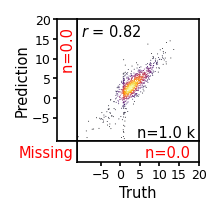

In [65]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=1000, random_state=1), 
    y_both.sample(n=1000, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_transduction/1st_vae_aa_nor_transduction_correlation_train.pdf',dpi=300,bbox_inches='tight')

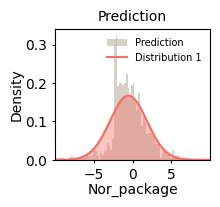

In [66]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 10, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
ax.set_xlim([-10,10])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_transduction/1st_vae_prediction_nor_transduction_distribution_train.pdf',dpi=300,bbox_inches='tight')

In [67]:
AA = test_df[array].values
X = test_df.drop(columns=['AA_sequence','Y--transduction'])
Y = test_df['Y--transduction'].values
preds_df = predict(model, X,array, Y=Y, AA=AA)
preds_df['y_pred'].corr(preds_df['y_true'])

32/32 [==============================] - 0s 615us/step

MSE of predictions vs true labels: 2.855494260787964


0.815939452337962

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


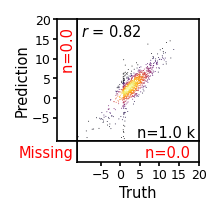

In [68]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=19, random_state=1), 
    y_both.sample(n=19, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_transduction/1st_vae_aa_nor_transduction_correlation_test.pdf',dpi=300,bbox_inches='tight')


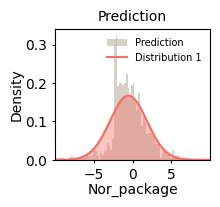

In [69]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 10, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
ax.set_xlim([-10,10])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_transduction/1st_vae_prediction_nor_transduction_distribution_test.pdf',dpi=300,bbox_inches='tight')